In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


#load in cleaned and transformed data file
df = pd.read_csv("Data\\Export\\central_dem_grades_clean.csv")

#convert date of birth column from str to datetime type, extract year, drop date column
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'], format = '%Y-%m-%d')
df['Birth_Year'] = df['Date_of_Birth'].dt.year
df = df.drop('Date_of_Birth', axis = 1)

#show first 5 rows
#df.head()


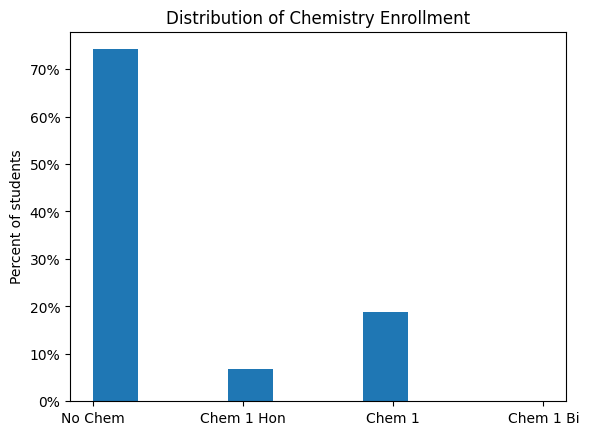

In [2]:
chem_enroll = df['chem11'].replace({0: 'No Chem',  1: "Chem 1", 2: "Chem 1 Hon", 5: "Chem 1 Bi"})
chem_enroll

plt.hist(chem_enroll, weights=np.ones(len(chem_enroll)) / len(chem_enroll))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title("Distribution of Chemistry Enrollment")
plt.ylabel("Percent of students")

plt.show()

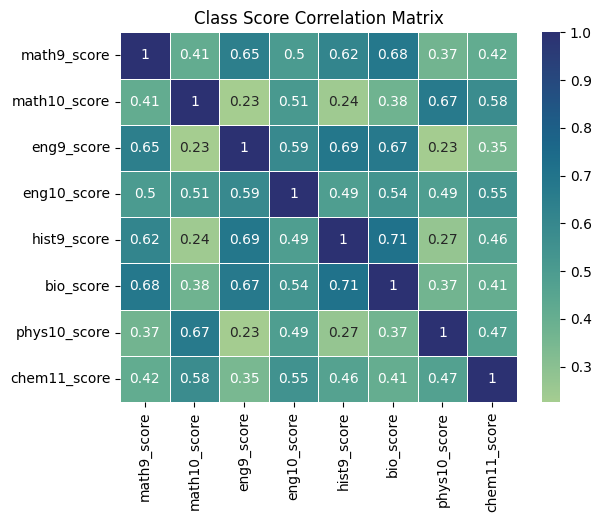

In [3]:
import seaborn as sn 
core_courses = ['math9_score', 'math10_score', 'eng9_score', 'eng10_score', 
                'hist9_score', 'bio_score', 'phys10_score', 'chem11_score']

corr_matrix = df[core_courses].corr()
#corr_matrix['chem11_score']

sn.heatmap(corr_matrix, annot=True, cmap = "crest", linewidths= 0.5)
plt.title("Class Score Correlation Matrix")
plt.show()

In [7]:
#asscociation rule mining for categorical data and Chem Grades
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

all_categories = ['ID', 'chem11', 'Gender', 'Counselor', 'ELL_Status', 
                  'Double_Math', 'FRPL_Status', 'Home_Language', 
                  'Race_Ethnicity', 'Special_Education_Status']

#replace coded values with text (must be string for encoder to work) for each column
df_rules = df[all_categories].set_index('ID')
df_rules['chem11'] = df_rules['chem11'].replace({0: 'No Chem', 1: "Chem 1", 2: "Chem 1 Hon", 5: "Chem 1 Bi"})
df_rules['Gender'] = df_rules['Gender'].replace({0: 'Female', 1: "Male"})
df_rules['Counselor'] = df_rules['Counselor'].astype(str)
df_rules['ELL_Status'] = df_rules['ELL_Status'].replace({False: 'NonELL', True: "ELL"})
df_rules['Double_Math'] = df_rules['Double_Math'].replace({0: 'Math1', 1: "Math2"})
df_rules['FRPL_Status'] = df_rules['FRPL_Status'].replace({1: 'Paid Lunch', 2: "Reduced Lunch", 3: "Free Lunch"})
df_rules['Home_Language'] = df_rules['Home_Language'].replace({0: 'English', 1: "Spanish"})
df_rules['Home_Language'] = df_rules['Home_Language'].replace([2, 3, 4, 5, 6], "Other")
df_rules['Race_Ethnicity'] = df_rules['Race_Ethnicity'].replace({5: 'White', 4: "Asian", 3: "Hispanic", 2: "Black", 1: "Multi", 0: "Native"})
df_rules['Special_Education_Status'] = df_rules['Special_Education_Status'].replace({False: 'NoSPED', True: "SPED"})

#convert df to list of lists
list_rules = df_rules.values.tolist()

te = TransactionEncoder()
te_ary = te.fit(list_rules).transform(list_rules)
df_rules2 = pd.DataFrame(te_ary, columns=te.columns_)

#create df of most common occuring demographic info
frequent_itemsets = fpgrowth(df_rules2, min_support=0.05, use_colnames=True)

#create rules based on lift metric
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
#rules.sort_values(['lift'], ascending = False)

#extract rules for Chem1
rules[rules["consequents"].apply(lambda x: 'Chem 1' in str(x))].sort_values(['lift'], ascending = False).head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
20874,"(Paid Lunch, NoSPED)","(NonELL, Chem 1, Hispanic)",0.219340,0.112028,0.050708,0.231183,2.063611,0.026135,1.154984,0.660226
20858,"(NonELL, Hispanic, Paid Lunch, NoSPED)",(Chem 1),0.133255,0.188679,0.050708,0.380531,2.016814,0.025565,1.309704,0.581680
20903,"(NonELL, Paid Lunch, NoSPED, Math1)",(Chem 1),0.168632,0.188679,0.062500,0.370629,1.964336,0.030683,1.289099,0.590499
20863,"(NonELL, Paid Lunch, NoSPED)","(Chem 1, Hispanic)",0.192217,0.134434,0.050708,0.263804,1.962329,0.024867,1.175727,0.607096
20913,"(Paid Lunch, NoSPED, Math1)","(NonELL, Chem 1)",0.195755,0.166274,0.062500,0.319277,1.920191,0.029951,1.224766,0.595861


In [8]:
#asscociation rule mining for categorical data and Chem Grades
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

all_categories = ['ID', 'chem11', 'Counselor']

#replace coded values with text (must be string for encoder to work) for each column
df_rules = df[all_categories].set_index('ID')
df_rules['chem11'] = df_rules['chem11'].replace({0: 'No Chem', 1: "Chem 1", 2: "Chem 1 Hon", 5: "Chem 1 Bi"})
df_rules['Counselor'] = df_rules['Counselor'].astype(str)


#convert df to list of lists
list_rules = df_rules.values.tolist()

te = TransactionEncoder()
te_ary = te.fit(list_rules).transform(list_rules)
df_rules2 = pd.DataFrame(te_ary, columns=te.columns_)

#create df of most common occuring demographic info
frequent_itemsets = fpgrowth(df_rules2, min_support=0.05, use_colnames=True)

#create rules based on lift metric
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
rules.sort_values(['lift'], ascending = False)

#extract rules for Chem1
#rules[rules["consequents"].apply(lambda x: 'Chem 1' in str(x))].sort_values(['lift'], ascending = False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(34),(No Chem),0.095519,0.741745,0.081368,0.851852,1.148443,0.010517,1.743219,0.142906
0,(19),(No Chem),0.120283,0.741745,0.100236,0.833333,1.123476,0.011016,1.549528,0.124933
3,(37),(No Chem),0.080189,0.741745,0.063679,0.794118,1.070607,0.004200,1.254380,0.071700
5,(22),(No Chem),0.101415,0.741745,0.077830,0.767442,1.034643,0.002606,1.110495,0.037262
1,(10),(No Chem),0.095519,0.741745,0.073113,0.765432,1.031934,0.002263,1.100981,0.034214
8,(28),(No Chem),0.074292,0.741745,0.055425,0.746032,1.005779,0.000318,1.016878,0.006207
7,(31),(No Chem),0.130896,0.741745,0.091981,0.702703,0.947364,-0.005111,0.868675,-0.060087
4,(25),(No Chem),0.121462,0.741745,0.082547,0.679612,0.916233,-0.007547,0.806068,-0.094256
6,(13),(No Chem),0.095519,0.741745,0.063679,0.666667,0.898781,-0.007171,0.774764,-0.110725
9,(16),(No Chem),0.084906,0.741745,0.051887,0.611111,0.823883,-0.011092,0.664084,-0.189364


In [11]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

#create list of categorical features
category_features = ['Gender', 'Counselor', 'ELL_Status', 'schoolName']

#use one hot encoder method to create an array of encoded data
ohn_data = pd.DataFrame(ohe.fit_transform(df[category_features]).toarray())

#create a dictionary of the encoded columns with meaningful names
ohn_columns = {0: 'Female', 1: 'Male', 2: 'Counselor10', 3: 'Counselor13', 4: 'Counselor16', 5: 'Counselor16', 6: 'Counselor19',
               7: 'Counselor22', 8: 'Counselor25', 9: 'Counselor28', 10: 'Counselor31', 11: 'Counselor34', 12: 'Counselor37', 
               13: 'Non-ELL', 14: 'ELL'}

#replace the column names with meaningful names
ohn_data = ohn_data.rename(columns=ohn_columns)

#create new df by joining categorical data array with non categorical array 
new_df = df.join(ohn_data)

#drop non encoded categorical data
new_df = new_df.drop(category_features, axis=1)

#drop all missing values 
new_df = new_df.dropna()

#create new idexes
new_df = new_df.set_index('ID')

new_df.head()

,math9,math9_score,math10,math10_score,eng9,eng9_score,eng10,eng10_score,hist9,hist9_score,...,Counselor16,Counselor19,Counselor22,Counselor25,Counselor28,Counselor31,Counselor34,Counselor37,Non-ELL,ELL
ID,,,,,,,,,,,,,,,,,,,,,
2241045,5,90.000000,1,81.439999,5,85.000000,2,94.489998,2,90.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2240018,1,81.834999,1,77.224998,2,69.349998,2,84.754997,2,73.639999,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2240019,1,90.310001,2,68.365002,1,95.625000,1,67.299999,1,92.969997,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2240020,1,84.369999,1,71.895000,1,96.684998,1,87.379997,1,85.254997,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2240031,1,54.220000,1,65.084999,1,67.159998,1,68.880001,1,73.365000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
#dimensionality reduction to plot chem scores vs other factors
#Factor analysis of mixed data https://pypi.org/project/prince/0.7.1/
from prince import FAMD

#drop NaN 
FAMD_df = df.dropna()

#drop chem course and score columns
FAMD_df2 = FAMD_df.drop(['chem11', 'chem11_score'], axis='columns')

#set up FAMD method
famd = FAMD(
     n_components=1,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='sklearn',
     random_state=42
)

famd =famd.fit(FAMD_df)

FAMD_1D = famd.row_coordinates(FAMD_df)

#create graph of reduced component and chem score with colors for courses
fig, ax = plt.subplots()
labels = {1: 'Chem 1', 2: 'Chem 1 Hon'}
scatter = ax.scatter(FAMD_1D, FAMD_df['chem11_score'], 
            c=FAMD_df['chem11'])

#create legend
legend = ax.legend(*scatter.legend_elements(),
                   title = 'Courses', 
                   loc = 'lower right')

#Add labels to graph 
plt.xlabel('Factor Analysis Score')
plt.ylabel('Chem11 Score')
plt.title("Chem scores based on attributes")

In [9]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Create feature and target arrays
X = new_df.drop(['chem11', 'chem11_score'], axis=1)
X = X.values
y = new_df['chem11']
y = y.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=903)
  
knn = KNeighborsClassifier(n_neighbors=3)
  
knn.fit(X_train, y_train)
  
# Predict on dataset which model has not seen before
pred =knn.predict(X_test) 

#print statistics to measure the model's performance 
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Confusion Matrix: \n", confusion_matrix(y_test, pred))
print("Accuracy Score:", accuracy_score(pred,y_test))
print("Precision:", precision_score(pred, y_test))
print("Recall:", recall_score(pred, y_test))


Confusion Matrix: 
 [[28  5]
 [ 9  1]]
Accuracy Score: 0.6744186046511628
Precision: 0.8484848484848485
Recall: 0.7567567567567568


In [10]:
#fuzzy c-means to predict student success in chemistry 
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score


def fuzzy_cluster(data, clusters, fuzzifier):
    data_df = pd.DataFrame(np.rot90(data), columns=["feature1", "feature2"])
    
    model = FCM(n_clusters = clusters, m=fuzzifier) #m is the fuzzifier
    model.fit(np.rot90(data))
    centers = model.centers
    #print("The centers are:  ", centers)
    err = model.error
    #print("The Error is:  ", err)

    labels = model.predict(np.rot90(data))
    #data_df['Cluster FCM'] = labels

    x = data_df['feature1']
    y = data_df['feature2']
    #label = data_df["Cluster FCM"]

    #Plot the data with different color clusters
    fig = plt.figure(figsize=(5,4))
    plt.scatter(x, y, c=labels)

    return data_df, labels

df_c_means = df

df_c_means['Chem11_grade'] = pd.cut(x=df_c_means['chem11_score'], 
                                     bins=[0, 59.5, 69.5, 79.5, 89.5, 100],
                                     labels = ['F', 'D', 'C', 'B', 'A'])

df_c_means = df.drop(['chem11', 'chem11_score'], axis = 1)


df_c_means.head()

,ID,math9,math9_score,math10,math10_score,eng9,eng9_score,eng10,eng10_score,hist9,...,Double_Math,FRPL_Status,Grade_Level,Home_Language,Race_Ethnicity,Transfer_Student,Special_Education_Status,schoolName,Birth_Year,Chem11_grade
0,2241070,5,75.0,0,NaN,1,90.0,5,65.000000,0,...,0,3,11,0,2,False,False,0,2005,NaN
1,2241070,5,75.0,0,NaN,1,90.0,1,95.239998,0,...,0,3,11,0,2,False,False,0,2005,NaN
2,4230947,5,70.0,4,70.800003,5,70.0,0,NaN,0,...,0,3,11,0,3,False,False,0,2006,NaN
3,2241042,5,95.0,0,NaN,5,65.0,1,83.730000,5,...,0,1,11,0,3,False,False,0,2005,NaN
4,2241045,5,90.0,1,81.439999,5,85.0,2,94.489998,2,...,0,2,11,0,3,False,False,0,2005,C
